*Теоретический материал:* https://youtu.be/6KmWDCavCtw?t=470

# Import библиотек

# Распознавание писателей

*Разбор данного раздела:* https://youtu.be/6KmWDCavCtw?t=4819

In [0]:
from google.colab import files #модуль для загрузки файлов в colab
import numpy as np #библиотека для работы с массивами данных
import pandas as pd #библиотека для обработки и анализа данных
import matplotlib.pyplot as plt #библиотека для визуализации данных
# "Магическая"команда python для запуска библиотеки в ноутбуке
%matplotlib inline

from tensorflow.keras import utils #модуль с утилитами кераса, будем использовать для вызова метода преобразования категорий в вектора
from tensorflow.keras.models import Sequential #последовательная модель нейросети кераса
# Загружаем стандартные слои нейросети(полносвязный, регуляризации, нормализации, векторного представления слов, выравнивания, активации)
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten, Activation
# Загружаем сверточные слои
from tensorflow.keras.layers import Conv1D, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
# Загружаем рекуррентные слои
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Bidirectional
# Загружаем алгоритмы обучения/оптимизации
from tensorflow.python.keras.optimizers import Adam, RMSprop

from keras.preprocessing.text import Tokenizer, text_to_word_sequence #инструменты предобработки текста от кераса
from sklearn.model_selection import train_test_split #модуль для разбиения данных на обучающую и тестовую выборки

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Загрузка данных

*Разбор данного раздела:* https://youtu.be/6KmWDCavCtw?t=4898

In [0]:
###########################
# Чтение файла в текст
##########################
def readText(fileName): # функция принимает имя файла
  f = open(fileName, 'r')        # задаем открытие нужного файла в режиме чтения
  text = f.read()                # читаем текст
  text = text.replace("\n", " ") # переносы строки переводим в пробелы
  
  return text                    # функция возвращает текст файла

# Загружаем обучающие тексты
trainText = []
trainText.append(readText('/content/drive/My Drive/Базы/Тексты писателей/(О. Генри) Обучающая_50 вместе.txt'))
trainText.append(readText('/content/drive/My Drive/Базы/Тексты писателей/(Стругацкие) Обучающая_5 вместе.txt'))
trainText.append(readText('/content/drive/My Drive/Базы/Тексты писателей/(Булгаков) Обучающая_5 вместе.txt'))
trainText.append(readText('/content/drive/My Drive/Базы/Тексты писателей/(Клиффорд_Саймак) Обучающая_5 вместе.txt'))
trainText.append(readText('/content/drive/My Drive/Базы/Тексты писателей/(Макс Фрай) Обучающая_5 вместе.txt'))
trainText.append(readText('/content/drive/My Drive/Базы/Тексты писателей/(Рэй Брэдберри) Обучающая_22 вместе.txt')) 

className = ["О. Генри", "Стругацкие", "Булгаков", "Саймак", "Фрай", "Брэдбери"]
nClasses = len(className)

# Загружаем тестовые тексты
testText = []
testText.append(readText('/content/drive/My Drive/Базы/Тексты писателей/(О. Генри) Тестовая_20 вместе.txt'))
testText.append(readText('/content/drive/My Drive/Базы/Тексты писателей/(Стругацкие) Тестовая_2 вместе.txt'))
testText.append(readText('/content/drive/My Drive/Базы/Тексты писателей/(Булгаков) Тестовая_2 вместе.txt'))
testText.append(readText('/content/drive/My Drive/Базы/Тексты писателей/(Клиффорд_Саймак) Тестовая_2 вместе.txt'))
testText.append(readText('/content/drive/My Drive/Базы/Тексты писателей/(Макс Фрай) Тестовая_2 вместе.txt'))
testText.append(readText('/content/drive/My Drive/Базы/Тексты писателей/(Рэй Брэдберри) Тестовая_8 вместе.txt'))

## Обработка данных


In [0]:
#################
# Преобразовываем текстовые данные в числовые/векторные для обучения нейросетью
#################

maxWordsCount = 20000 # определяем макс.кол-во слов/индексов, учитываемое при обучении текстов

# для этого воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
tokenizer = Tokenizer(num_words=maxWordsCount, filters='–—!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\xa0–\ufeff', lower=True, split=' ', char_level=False, oov_token = 'unknown')
# выше задаем параметры:
# (num_words=maxWordsCount) - определяем макс.кол-во слов/индексов, учитываемое при обучении текстов
# (filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n') - избавляемся от ненужных символов
# (lower=True) - приводим слова к нижнему регистру
# (split=' ') - разделяем слова по пробелу
# (char_level=False) - просим токенайзер не удалять однобуквенные слова

tokenizer.fit_on_texts(trainText) #"скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items()) #вытаскиваем индексы слов для просмотра

In [0]:
print(items[:100]) # взглянем на содержимое словаря

[('unknown', 1), ('и', 2), ('в', 3), ('не', 4), ('я', 5), ('что', 6), ('на', 7), ('с', 8), ('он', 9), ('а', 10), ('как', 11), ('то', 12), ('это', 13), ('но', 14), ('все', 15), ('у', 16), ('по', 17), ('его', 18), ('к', 19), ('так', 20), ('мне', 21), ('из', 22), ('за', 23), ('меня', 24), ('ты', 25), ('же', 26), ('сказал', 27), ('бы', 28), ('было', 29), ('вы', 30), ('от', 31), ('они', 32), ('мы', 33), ('только', 34), ('да', 35), ('еще', 36), ('она', 37), ('о', 38), ('когда', 39), ('вот', 40), ('уже', 41), ('если', 42), ('был', 43), ('ни', 44), ('их', 45), ('нет', 46), ('чтобы', 47), ('до', 48), ('ну', 49), ('для', 50), ('ему', 51), ('может', 52), ('или', 53), ('ничего', 54), ('даже', 55), ('там', 56), ('очень', 57), ('кто', 58), ('ее', 59), ('тут', 60), ('потом', 61), ('просто', 62), ('него', 63), ('чем', 64), ('быть', 65), ('теперь', 66), ('под', 67), ('где', 68), ('нас', 69), ('есть', 70), ('тебя', 71), ('время', 72), ('ли', 73), ('тебе', 74), ('со', 75), ('во', 76), ('вас', 77), ('раз'

In [0]:
print("Протестируем словарь частотности")
print("Интересующее слово имеет индекс: ", tokenizer.word_index[input("уточните слово: ")]) #протестируем словарь частотности

Протестируем словарь частотности
уточните слово: белая
Интересующее слово имеет индекс:  3713


In [0]:
# преобразовываем текст в последовательность индексов согласно частотному словарю
trainWordIndexes = tokenizer.texts_to_sequences(trainText) # обучающие тесты в индексы
testWordIndexes = tokenizer.texts_to_sequences(testText)   # проверочные тесты в индексы

print("Взглянем на фрагмент обучающего текста:")
print("В виде оригинального текста:              ", trainText[1] [:87])
print("Он же в виде последовательности индексов: ", trainWordIndexes[1][:20])

print()
print()

print("Статистика по обучающим текстам:")
for i in range(6):
  print(className[i], " ", len(trainText[i]), " символов, ", len(trainWordIndexes[i]), " слов")
print("В сумме ", len(trainText[0])+len(trainText[1])+len(trainText[2])+len(trainText[3])+len(trainText[4])+len(trainText[5]), " символов, ", len(trainWordIndexes[0])+len(trainWordIndexes[1])+len(trainWordIndexes[2])+len(trainWordIndexes[3])+len(trainWordIndexes[4])+len(trainWordIndexes[5]), " слов")
print()
print("Статистика по обучающим текстам:")
for i in range(6):
  print(className[i], " ", len(testText[i]), " символов, ", len(testWordIndexes[i]), " слов")
print("В сумме ", len(testText[0])+len(testText[1])+len(testText[2])+len(testText[3])+len(testText[4])+len(testText[5]), " символов, ", len(testWordIndexes[0])+len(testWordIndexes[1])+len(testWordIndexes[2])+len(testWordIndexes[3])+len(testWordIndexes[4])+len(testWordIndexes[5]), " слов")

Взглянем на фрагмент обучающего текста:
В виде оригинального текста:               Парень из преисподней     1     Ну и деревня! Сроду я таких деревень не видел и не знал
Он же в виде последовательности индексов:  [470, 22, 1, 1482, 49, 2, 12725, 7723, 5, 415, 1, 4, 252, 2, 4, 247, 55, 6, 240, 10517]


Статистика по обучающим текстам:
О. Генри   1049517  символов,  160682  слов
Стругацкие   2042469  символов,  313405  слов
Булгаков   1765648  символов,  262109  слов
Саймак   1609507  символов,  251551  слов
Фрай   3700010  символов,  569052  слов
Брэдбери   1386454  символов,  214694  слов
В сумме  11553605  символов,  1771493  слов

Статистика по обучающим текстам:
О. Генри   349662  символов,  53255  слов
Стругацкие   704846  символов,  108730  слов
Булгаков   875042  символов,  132910  слов
Саймак   318811  символов,  50362  слов
Фрай   1278191  символов,  196911  слов
Брэдбери   868673  символов,  132746  слов
В сумме  4395225  символов,  674914  слов


## Создание обучающей и проверочной выборки

**Функции для формирования выборки по отрезкам текста с заданным шагом**

In [0]:
###########################
# Формирование обучающей выборки по листу индексов слов
# (разделение на короткие векторы)
##########################
def getSetFromIndexes(wordIndexes, xLen, step):
  xSample = []
  wordsLen = len(wordIndexes)
  index = 0
  
  # Идём по всей длине вектора индексов
  # "Откусываем" векторы длины xLen и смещаеммся вперёд на step
  
  while (index + xLen <= wordsLen):
    xSample.append(wordIndexes[index:index+xLen])
    index += step
    
  return xSample

In [0]:
###########################
# Формирование обучающей и проверочной выборки
# Из двух листов индексов от двух классов
##########################
def createSetsMultiClasses(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна, шаг окна

  # Для каждого из 6 классов
  # Создаём обучающую/проверочную выборку из индексов
  nClasses = len(wordIndexes) # задаем количество классов выборки
  classesXSamples = []        # здесь будет список размером "кол-во классов*кол-во окон в тексте*длину окна(например 6 по 1341*1000)"
  for wI in wordIndexes:      # для каждого текста выборки из последовательности индексов
    classesXSamples.append(getSetFromIndexes(wI, xLen, step)) # добавляем в список очередной текст индексов, разбитый на "кол-во окон*длину окна" 

  # Формируем один общий xSamples
  xSamples = [] # здесь будет список размером "суммарное кол-во окон во всех текстах*длину окна(например 15779*1000)"
  ySamples = [] # здесь будет список размером "суммарное кол-во окон во всех текстах*вектор длиной 6"
  
  for t in range(nClasses):  # в диапазоне кол-ва классов(6)
    xT = classesXSamples[t]  # берем очередной текст вида "кол-во окон в тексте*длину окна"(например 1341*1000)
    for i in range(len(xT)): # и каждое его окно
      xSamples.append(xT[i]) # добавляем в общий список выборки
    
    # Формируем ySamples по номеру класса
    currY = utils.to_categorical(t, nClasses) # текущий класс переводится в вектор длиной 6 вида [0.0.0.1.0.0.]
    for i in range(len(xT)): # на каждое окно выборки 
      ySamples.append(currY) # добавляем соответствующий вектор класса

  xSamples = np.array(xSamples) # переводим в массив numpy для подачи в нейронку
  ySamples = np.array(ySamples) # переводим в массив numpy для подачи в нейронку

  
  return (xSamples, ySamples)   # функция возвращает выборку и соответствующие векторы классов

**Подготовка данных**

In [0]:
# Задаём базовые параметры
xLen = 1000 # Длина отрезка текста, по которой анализируем, в словах
step = 100 # Шаг разбиения исходного текста на обучающие вектора

In [0]:
# Формируем обучающую и тестовую выборку
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) # извлекаем обучающую выборку
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    # извлекаем тестовую выборку
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)
# получили обучающий/тестовый набор, достаточный для запуска Embedding, но для Bag of Words нужно xTrain и xTest представить в виде векторов из 0 и 1

(17658, 1000)
(17658, 6)
(6693, 1000)
(6693, 6)


## Распознавание проверочной выборки


In [0]:
###########################
# Представляем тестовую выборку в удобных для распознавания размерах
##########################
def createTestMultiClasses(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна, шаг окна

  # Для каждого из 6 классов
  # Создаём тестовую выборку из индексов
  nClasses = len(wordIndexes) # задаем количество классов
  xTest6Classes01 = []               # здесь будет список из всех классов,каждый размером "кол-во окон в тексте * 20000(при maxWordsCount=20000)"
  xTest6Classes = []                 # здесь будет список массивов, каждый размером "кол-во окон в тексте * длину окна"(6 по 420*1000)
  for wI in wordIndexes:             # для каждого тестового текста из последовательности индексов
    sample = (getSetFromIndexes(wI, xLen, step)) # тестовая выборка размером "кол-во окон*длину окна"(например 420*1000)
    xTest6Classes.append(np.array(sample))       # переводим в массив numpy и добавляем в список
    xTest6Classes01.append(tokenizer.sequences_to_matrix(sample)) # трансформируется в Bag of Words в виде "кол-во окон в тексте * 20000"
  xTest6Classes01 = np.array(xTest6Classes01)                     # и добавляется к нашему списку, 
  
  return xTest6Classes01, xTest6Classes # функция вернёт тестовые данные: TestBg 6 классов на n*20000 и xTestEm 6 по n*1000

###########################
# Расспознаём тестовую выборку и выводим результаты
##########################
def recognizeMultiClass(model, xTest, modelName):
  print("НЕЙРОНКА: ", modelName)
  print()
  
  val = []
  pred = []
  
  totalSumRec = []
  
  # Проходим по всем классам
  for i in range(nClasses):
    # Получаем результаты распознавания класса по блокам слов длины xLen
    currPred = model.predict(xTest[i])
    pred.append(currPred)
    # Определяем номер распознанного класса для каждохо блока слов длины xLen
    currOut = np.argmax(currPred, axis=1)
    
    # Считаем процент распознавания каждого класса за каждый
    # Получам матрицу 6 на 6
    evVal = []
    sumRec = []
    for j in range(nClasses):
      sumRec.append(0)
      for t in range(len(currOut)):
        if (currOut[t] == j):
          sumRec[j] += 1
      evVal.append(sumRec[j] / len(currOut))
    
    totalSumRec.append(sumRec[i])
    
    # Определяем, какой в класс в итоге за какой был распознан
    val.append(evVal[i])
    recognizedClass = np.argmax(evVal)
    
    # Выводим результаты распознавания по текущему классу
    isRecognized = "распознано НЕ ВЕРНО!"
    if (recognizedClass == i):
      isRecognized = "распознано ВЕРНО!"
    print(className[i], " распознано ", int(100*evVal[i]), "% сеть считает, что это ", className[recognizedClass], ", ", isRecognized)
  
  # Выводим вредний процент распознавания по всем классам вместе
  print()
  sumVal = 0
  sumCount = 0
  lenXtest = []
  for i in range(nClasses):
    sumCount += len(xTest[i])
    sumVal += totalSumRec[i]
  print("Средний процент распознавания ", int(100*sumVal/sumCount), "%")
  print()
  return sumVal/sumCount

xTest6Classes01, xTest6Classes = createTestMultiClasses(testWordIndexes, xLen, step) # подгоним форму тестовых классов под функцию recognizeMultiClass

## Рекуррентная нейросеть

**Simple RNN / GRU / LSTM**

*Разбор данного раздела:* https://youtu.be/6KmWDCavCtw?t=5098

Epoch 1/2
35/35 [==============================] - 54s 2s/step - loss: 1.8046 - accuracy: 0.2729 - val_loss: 1.7809 - val_accuracy: 0.2928
Epoch 2/2
35/35 [==============================] - 54s 2s/step - loss: 1.7511 - accuracy: 0.3064 - val_loss: 1.7724 - val_accuracy: 0.2928


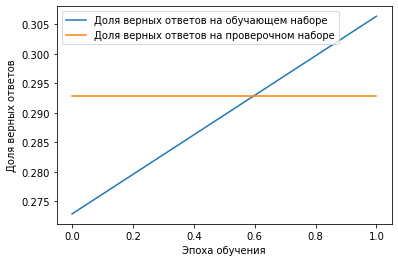

НЕЙРОНКА:  SimpleRNN

О. Генри  распознано  0 % сеть считает, что это  Фрай ,  распознано НЕ ВЕРНО!
Стругацкие  распознано  0 % сеть считает, что это  Фрай ,  распознано НЕ ВЕРНО!
Булгаков  распознано  0 % сеть считает, что это  Фрай ,  распознано НЕ ВЕРНО!
Саймак  распознано  0 % сеть считает, что это  Фрай ,  распознано НЕ ВЕРНО!
Фрай  распознано  100 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдбери  распознано  0 % сеть считает, что это  Фрай ,  распознано НЕ ВЕРНО!

Средний процент распознавания  29 %



In [0]:
modelEL = Sequential() # создаём последовательную модель нейросети

# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelEL.add(Embedding(maxWordsCount, 5, input_length=xLen))

modelEL.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelEL.add(BatchNormalization()) # добавляем слой нормализации данных
modelEL.add(SimpleRNN(4, dropout=0.2, recurrent_dropout=0.2, activation="relu"))
modelEL.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelEL.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = modelEL.fit(xTrain, 
                    yTrain, 
                    epochs=2,
                    batch_size=512,
                    validation_data=(xTest, yTest))

# Строим график для отображения динамики обучения и точности предсказания сети
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

pred = recognizeMultiClass(modelEL, xTest6Classes, "SimpleRNN") #функция покажет какие классы и как распознаны верно

Epoch 1/2
35/35 [==============================] - 165s 5s/step - loss: 1.8270 - accuracy: 0.1424 - val_loss: 1.7854 - val_accuracy: 0.2928
Epoch 2/2
35/35 [==============================] - 165s 5s/step - loss: 1.7744 - accuracy: 0.1980 - val_loss: 1.7793 - val_accuracy: 0.2928


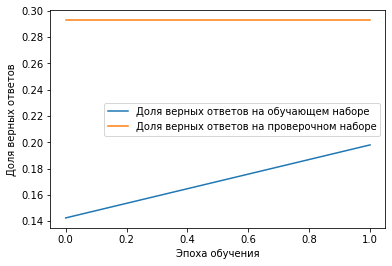

НЕЙРОНКА:  Embedding + LSTM

О. Генри  распознано  0 % сеть считает, что это  Фрай ,  распознано НЕ ВЕРНО!
Стругацкие  распознано  0 % сеть считает, что это  Фрай ,  распознано НЕ ВЕРНО!
Булгаков  распознано  0 % сеть считает, что это  Фрай ,  распознано НЕ ВЕРНО!
Саймак  распознано  0 % сеть считает, что это  Фрай ,  распознано НЕ ВЕРНО!
Фрай  распознано  100 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдбери  распознано  0 % сеть считает, что это  Фрай ,  распознано НЕ ВЕРНО!

Средний процент распознавания  29 %



In [0]:
modelEL = Sequential() # создаём последовательную модель нейросети

# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelEL.add(Embedding(maxWordsCount, 5, input_length=xLen))

modelEL.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelEL.add(BatchNormalization()) # добавляем слой нормализации данных
modelEL.add(GRU(4, dropout=0.2, recurrent_dropout=0.2, activation="relu"))
modelEL.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelEL.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = modelEL.fit(xTrain, 
                    yTrain, 
                    epochs=2,
                    batch_size=512,
                    validation_data=(xTest, yTest))

# Строим график для отображения динамики обучения и точности предсказания сети
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

pred = recognizeMultiClass(modelEL, xTest6Classes, "Embedding + LSTM") #функция покажет какие классы и как распознаны верно

Epoch 1/20
35/35 [==============================] - 7s 187ms/step - loss: 1.7397 - accuracy: 0.2923 - val_loss: 1.7625 - val_accuracy: 0.2928
Epoch 2/20
35/35 [==============================] - 6s 173ms/step - loss: 1.6560 - accuracy: 0.3575 - val_loss: 1.7425 - val_accuracy: 0.2928
Epoch 3/20
35/35 [==============================] - 6s 173ms/step - loss: 1.5770 - accuracy: 0.3970 - val_loss: 1.6861 - val_accuracy: 0.2927
Epoch 4/20
35/35 [==============================] - 6s 173ms/step - loss: 1.4743 - accuracy: 0.4551 - val_loss: 1.7929 - val_accuracy: 0.1978
Epoch 5/20
35/35 [==============================] - 6s 173ms/step - loss: 1.3670 - accuracy: 0.5220 - val_loss: 1.8169 - val_accuracy: 0.1974
Epoch 6/20
35/35 [==============================] - 6s 173ms/step - loss: 1.2746 - accuracy: 0.5604 - val_loss: 1.8403 - val_accuracy: 0.1975
Epoch 7/20
35/35 [==============================] - 6s 173ms/step - loss: 1.2091 - accuracy: 0.5777 - val_loss: 1.7527 - val_accuracy: 0.2555
Epoch 

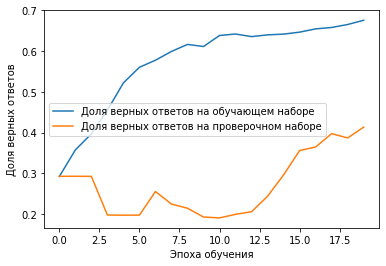

НЕЙРОНКА:  Embedding + LSTM

О. Генри  распознано  0 % сеть считает, что это  Булгаков ,  распознано НЕ ВЕРНО!
Стругацкие  распознано  45 % сеть считает, что это  Булгаков ,  распознано НЕ ВЕРНО!
Булгаков  распознано  69 % сеть считает, что это  Булгаков ,  распознано ВЕРНО!
Саймак  распознано  15 % сеть считает, что это  Булгаков ,  распознано НЕ ВЕРНО!
Фрай  распознано  65 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдбери  распознано  0 % сеть считает, что это  Стругацкие ,  распознано НЕ ВЕРНО!

Средний процент распознавания  41 %



In [0]:
modelEL = Sequential() # создаём последовательную модель нейросети

# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelEL.add(Embedding(maxWordsCount, 5, input_length=xLen))

modelEL.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelEL.add(BatchNormalization()) # добавляем слой нормализации данных
modelEL.add(LSTM(4))
modelEL.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelEL.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = modelEL.fit(xTrain, 
                    yTrain, 
                    epochs=20,
                    batch_size=512,
                    validation_data=(xTest, yTest))

# Строим график для отображения динамики обучения и точности предсказания сети
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

pred = recognizeMultiClass(modelEL, xTest6Classes, "Embedding + LSTM") #функция покажет какие классы и как распознаны верно

Epoch 1/50
35/35 [==============================] - 12s 350ms/step - loss: 1.7362 - accuracy: 0.2219 - val_loss: 1.7686 - val_accuracy: 0.1611
Epoch 2/50
35/35 [==============================] - 11s 327ms/step - loss: 1.6170 - accuracy: 0.3043 - val_loss: 1.7769 - val_accuracy: 0.2928
Epoch 3/50
35/35 [==============================] - 11s 327ms/step - loss: 1.4946 - accuracy: 0.4453 - val_loss: 1.8158 - val_accuracy: 0.2928
Epoch 4/50
35/35 [==============================] - 11s 327ms/step - loss: 1.3876 - accuracy: 0.4604 - val_loss: 1.7584 - val_accuracy: 0.1972
Epoch 5/50
35/35 [==============================] - 11s 327ms/step - loss: 1.3159 - accuracy: 0.4617 - val_loss: 1.7565 - val_accuracy: 0.1992
Epoch 6/50
35/35 [==============================] - 11s 327ms/step - loss: 1.2658 - accuracy: 0.4649 - val_loss: 1.7679 - val_accuracy: 0.1978
Epoch 7/50
35/35 [==============================] - 11s 327ms/step - loss: 1.2347 - accuracy: 0.4632 - val_loss: 1.7676 - val_accuracy: 0.2078

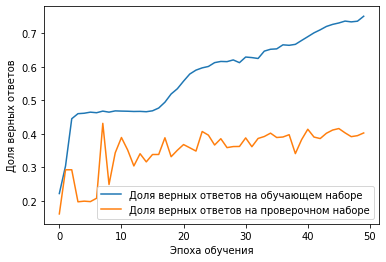

НЕЙРОНКА:  Embedding + LSTM

О. Генри  распознано  0 % сеть считает, что это  Саймак ,  распознано НЕ ВЕРНО!
Стругацкие  распознано  64 % сеть считает, что это  Стругацкие ,  распознано ВЕРНО!
Булгаков  распознано  31 % сеть считает, что это  Стругацкие ,  распознано НЕ ВЕРНО!
Саймак  распознано  40 % сеть считает, что это  Саймак ,  распознано ВЕРНО!
Фрай  распознано  68 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдбери  распознано  2 % сеть считает, что это  Стругацкие ,  распознано НЕ ВЕРНО!

Средний процент распознавания  40 %



In [0]:
modelEL = Sequential() # создаём последовательную модель нейросети

# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelEL.add(Embedding(maxWordsCount, 5, input_length=xLen))

modelEL.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelEL.add(BatchNormalization())  # добавляем слой нормализации данных
modelEL.add(LSTM(4, return_sequences=1))
modelEL.add(LSTM(4))
modelEL.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelEL.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = modelEL.fit(xTrain, 
                    yTrain, 
                    epochs=50,
                    batch_size=512,
                    validation_data=(xTest, yTest))

# Строим график для отображения динамики обучения и точности предсказания сети
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

pred = recognizeMultiClass(modelEL, xTest6Classes, "Embedding + LSTM") # функция покажет какие классы и как распознаны верно

**LSTM + Dense**

*Разбор данного раздела:* https://youtu.be/6KmWDCavCtw?t=5505

Epoch 1/20
89/89 [==============================] - 15s 172ms/step - loss: 2.0819 - accuracy: 0.2140 - val_loss: 1.7339 - val_accuracy: 0.2928
Epoch 2/20
89/89 [==============================] - 14s 163ms/step - loss: 1.8928 - accuracy: 0.2622 - val_loss: 1.7421 - val_accuracy: 0.2928
Epoch 3/20
89/89 [==============================] - 14s 163ms/step - loss: 1.8118 - accuracy: 0.2856 - val_loss: 1.7392 - val_accuracy: 0.2928
Epoch 4/20
89/89 [==============================] - 14s 163ms/step - loss: 1.7386 - accuracy: 0.3041 - val_loss: 1.7221 - val_accuracy: 0.2928
Epoch 5/20
89/89 [==============================] - 14s 163ms/step - loss: 1.6657 - accuracy: 0.3409 - val_loss: 1.7045 - val_accuracy: 0.2988
Epoch 6/20
89/89 [==============================] - 14s 163ms/step - loss: 1.5347 - accuracy: 0.3907 - val_loss: 2.2072 - val_accuracy: 0.2999
Epoch 7/20
89/89 [==============================] - 14s 162ms/step - loss: 1.4184 - accuracy: 0.4326 - val_loss: 1.8208 - val_accuracy: 0.2985

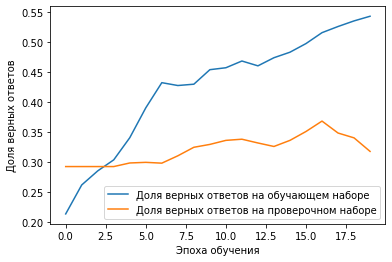

НЕЙРОНКА:  Embedding + LSTM

О. Генри  распознано  0 % сеть считает, что это  Стругацкие ,  распознано НЕ ВЕРНО!
Стругацкие  распознано  30 % сеть считает, что это  Саймак ,  распознано НЕ ВЕРНО!
Булгаков  распознано  6 % сеть считает, что это  Стругацкие ,  распознано НЕ ВЕРНО!
Саймак  распознано  53 % сеть считает, что это  Саймак ,  распознано ВЕРНО!
Фрай  распознано  73 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдбери  распознано  0 % сеть считает, что это  Стругацкие ,  распознано НЕ ВЕРНО!

Средний процент распознавания  31 %



In [0]:
modelEL = Sequential() # создаём последовательную модель нейросети
# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelEL.add(Embedding(maxWordsCount, 10, input_length=xLen))

modelEL.add(SpatialDropout1D(0.4)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelEL.add(BatchNormalization())  # добавляем слой нормализации данных
modelEL.add(LSTM(4)) # добавляем слой LSTM, совместимый с Cuda при поддержке GPU
modelEL.add(Dropout(0.5)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEL.add(BatchNormalization()) # добавляем слой нормализации данных
modelEL.add(Dense(100, activation="relu")) # добавляем полносвязный слой с указанием количества нейронов и функции активации
modelEL.add(Dropout(0.5)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEL.add(BatchNormalization()) # добавляем слой нормализации данных
modelEL.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelEL.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = modelEL.fit(xTrain, 
                    yTrain, 
                    epochs=20,
                    batch_size=200,
                    validation_data=(xTest, yTest))

# Строим график для отображения динамики обучения и точности предсказания сети
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

pred = recognizeMultiClass(modelEL, xTest6Classes, "Embedding + LSTM") # функция покажет какие классы и как распознаны верно

**LSTM + Dense через последовательности**

Epoch 1/30
89/89 [==============================] - 15s 168ms/step - loss: 2.6366 - accuracy: 0.4975 - val_loss: 2.1228 - val_accuracy: 0.3350
Epoch 2/30
89/89 [==============================] - 14s 160ms/step - loss: 0.8675 - accuracy: 0.8278 - val_loss: 6.3487 - val_accuracy: 0.3049
Epoch 3/30
89/89 [==============================] - 14s 160ms/step - loss: 0.4245 - accuracy: 0.9228 - val_loss: 4.4378 - val_accuracy: 0.3805
Epoch 4/30
89/89 [==============================] - 14s 160ms/step - loss: 0.3152 - accuracy: 0.9490 - val_loss: 6.7381 - val_accuracy: 0.3254
Epoch 5/30
89/89 [==============================] - 14s 160ms/step - loss: 0.2601 - accuracy: 0.9608 - val_loss: 5.7987 - val_accuracy: 0.5362
Epoch 6/30
89/89 [==============================] - 14s 160ms/step - loss: 0.2863 - accuracy: 0.9651 - val_loss: 3.3266 - val_accuracy: 0.5988
Epoch 7/30
89/89 [==============================] - 14s 160ms/step - loss: 0.2340 - accuracy: 0.9688 - val_loss: 3.4235 - val_accuracy: 0.6531

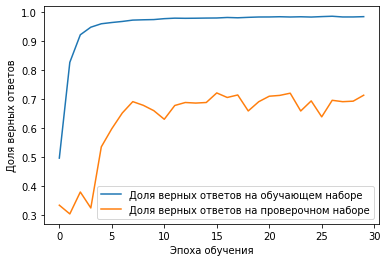

НЕЙРОНКА:  Embedding + LSTM

О. Генри  распознано  41 % сеть считает, что это  О. Генри ,  распознано ВЕРНО!
Стругацкие  распознано  80 % сеть считает, что это  Стругацкие ,  распознано ВЕРНО!
Булгаков  распознано  73 % сеть считает, что это  Булгаков ,  распознано ВЕРНО!
Саймак  распознано  57 % сеть считает, что это  Саймак ,  распознано ВЕРНО!
Фрай  распознано  64 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдбери  распознано  89 % сеть считает, что это  Брэдбери ,  распознано ВЕРНО!

Средний процент распознавания  71 %



In [0]:
modelEL = Sequential() # создаём последовательную модель нейросети
# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelEL.add(Embedding(maxWordsCount, 10, input_length=xLen))

modelEL.add(SpatialDropout1D(0.4)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelEL.add(BatchNormalization())  # добавляем слой нормализации данных
modelEL.add(LSTM(4, return_sequences=1)) # добавляем слой LSTM, совместимый с Cuda при поддержке GPU
modelEL.add(Dropout(0.5)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEL.add(BatchNormalization()) # добавляем слой нормализации данных
modelEL.add(Dense(100, activation="relu")) # добавляем полносвязный слой с указанием количества нейронов и функции активации
modelEL.add(Dropout(0.5)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEL.add(BatchNormalization()) # добавляем слой нормализации данных
modelEL.add(Flatten()) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
modelEL.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelEL.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = modelEL.fit(xTrain, 
                    yTrain, 
                    epochs=30,
                    batch_size=200,
                    validation_data=(xTest, yTest))

# Строим график для отображения динамики обучения и точности предсказания сети
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

pred = recognizeMultiClass(modelEL, xTest6Classes, "Embedding + LSTM") #функция покажет какие классы и как распознаны верно

**Двунаправленная LSTM**

*Разбор данного раздела:* https://youtu.be/6KmWDCavCtw?t=5545

Epoch 1/5
89/89 [==============================] - 89s 1s/step - loss: 0.0232 - accuracy: 0.9938 - val_loss: 3.0209 - val_accuracy: 0.4696
Epoch 2/5
89/89 [==============================] - 87s 982ms/step - loss: 0.0130 - accuracy: 0.9968 - val_loss: 2.7210 - val_accuracy: 0.5961
Epoch 3/5
89/89 [==============================] - 88s 983ms/step - loss: 0.0148 - accuracy: 0.9957 - val_loss: 3.4298 - val_accuracy: 0.5924
Epoch 4/5
89/89 [==============================] - 87s 983ms/step - loss: 0.0175 - accuracy: 0.9963 - val_loss: 2.9432 - val_accuracy: 0.5667
Epoch 5/5
89/89 [==============================] - 88s 985ms/step - loss: 0.0084 - accuracy: 0.9978 - val_loss: 2.4868 - val_accuracy: 0.5818


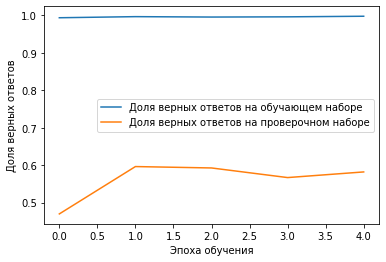

НЕЙРОНКА:  Embedding + LSTM

О. Генри  распознано  72 % сеть считает, что это  О. Генри ,  распознано ВЕРНО!
Стругацкие  распознано  31 % сеть считает, что это  Фрай ,  распознано НЕ ВЕРНО!
Булгаков  распознано  27 % сеть считает, что это  Фрай ,  распознано НЕ ВЕРНО!
Саймак  распознано  37 % сеть считает, что это  Фрай ,  распознано НЕ ВЕРНО!
Фрай  распознано  97 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдбери  распознано  54 % сеть считает, что это  Брэдбери ,  распознано ВЕРНО!

Средний процент распознавания  58 %



In [0]:
modelEL = Sequential() #создаём последовательную модель нейросети

#преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelEL.add(Embedding(maxWordsCount, 50, input_length=xLen))

modelEL.add(SpatialDropout1D(0.4)) #добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelEL.add(BatchNormalization()) #добавляем слой нормализации данных
modelEL.add(Bidirectional(LSTM(8, return_sequences=1))) #добавляем слой с двунаправленным LSTM, совместимый с Cuda при поддержке GPU
modelEL.add(Bidirectional(LSTM(8, return_sequences=1))) #добавляем слой с двунаправленным LSTM, совместимый с Cuda при поддержке GPU
modelEL.add(Dropout(0.3)) #добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEL.add(BatchNormalization()) #добавляем слой нормализации данных
modelEL.add(GRU(16, return_sequences=1,reset_after=True)) #добавляем слой GRU, совместимый с Cuda при поддержке GPU
modelEL.add(GRU(16, reset_after=True)) #добавляем слой GRU, совместимый с Cuda при поддержке GPU
modelEL.add(Dropout(0.3)) #добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEL.add(BatchNormalization()) #добавляем слой нормализации данных
modelEL.add(Dense(200, activation='relu')) #добавляем полносвязный слой с указанием количества нейронов и функции активации
modelEL.add(Dropout(0.3)) #добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEL.add(BatchNormalization()) #добавляем слой нормализации данных
modelEL.add(Dense(6, activation='softmax')) #добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelEL.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = modelEL.fit(xTrain, 
                    yTrain, 
                    epochs=5,
                    batch_size=200,
                    validation_data=(xTest, yTest))

# Строим график для отображения динамики обучения и точности предсказания сети
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

pred = recognizeMultiClass(modelEL, xTest6Classes, "Embedding + LSTM") #функция покажет какие классы и как распознаны верно

## Conv1D

*Разбор данного раздела:* https://youtu.be/6KmWDCavCtw?t=5650

Epoch 1/20
89/89 [==============================] - 2s 24ms/step - loss: 1.2426 - accuracy: 0.5672 - val_loss: 1.9331 - val_accuracy: 0.2556
Epoch 2/20
89/89 [==============================] - 2s 21ms/step - loss: 0.0682 - accuracy: 0.9786 - val_loss: 2.5123 - val_accuracy: 0.2928
Epoch 3/20
89/89 [==============================] - 2s 21ms/step - loss: 0.0150 - accuracy: 0.9952 - val_loss: 2.5013 - val_accuracy: 0.2586
Epoch 4/20
89/89 [==============================] - 2s 27ms/step - loss: 0.0137 - accuracy: 0.9956 - val_loss: 2.9398 - val_accuracy: 0.3566
Epoch 5/20
89/89 [==============================] - 2s 22ms/step - loss: 0.0092 - accuracy: 0.9969 - val_loss: 3.0516 - val_accuracy: 0.3886
Epoch 6/20
89/89 [==============================] - 2s 22ms/step - loss: 0.0113 - accuracy: 0.9967 - val_loss: 1.2127 - val_accuracy: 0.6540
Epoch 7/20
89/89 [==============================] - 2s 22ms/step - loss: 0.0102 - accuracy: 0.9972 - val_loss: 2.0118 - val_accuracy: 0.5687
Epoch 8/20
89

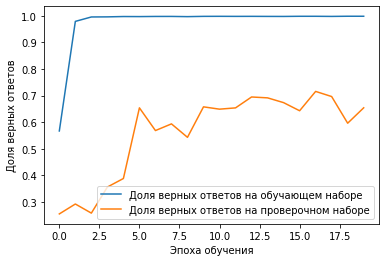

НЕЙРОНКА:  Embedding + Dense

О. Генри  распознано  22 % сеть считает, что это  Булгаков ,  распознано НЕ ВЕРНО!
Стругацкие  распознано  34 % сеть считает, что это  Фрай ,  распознано НЕ ВЕРНО!
Булгаков  распознано  78 % сеть считает, что это  Булгаков ,  распознано ВЕРНО!
Саймак  распознано  42 % сеть считает, что это  Саймак ,  распознано ВЕРНО!
Фрай  распознано  95 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдбери  распознано  59 % сеть считает, что это  Брэдбери ,  распознано ВЕРНО!

Средний процент распознавания  65 %



In [0]:
modelEC = Sequential() # создаём последовательную модель нейросети
# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelEC.add(Embedding(maxWordsCount, 10, input_length=xLen))

modelEC.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelEC.add(BatchNormalization())  # добавляем слой нормализации данных
modelEC.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
#modelEC.add(MaxPooling1D(2)) # добавляем слой подвыборки/пулинга с функцией максимума
modelEC.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
modelEC.add(MaxPooling1D(2)) # добавляем слой подвыборки/пулинга с функцией максимума
modelEC.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEC.add(BatchNormalization()) # добавляем слой нормализации данных
modelEC.add(Flatten()) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
modelEC.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelEC.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = modelEC.fit(xTrain, 
                    yTrain, 
                    epochs=20,
                    batch_size=200,
                    validation_data=(xTest, yTest))

# Строим график для отображения динамики обучения и точности предсказания сети
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

pred = recognizeMultiClass(modelEC, xTest6Classes, "Embedding + Dense") #функция покажет какие классы и как распознаны верно

In [0]:
print(modelEC.summary()) # выведем на экран данные о модели

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 1000, 10)          200000    
_________________________________________________________________
spatial_dropout1d_15 (Spatia (None, 1000, 10)          0         
_________________________________________________________________
batch_normalization_39 (Batc (None, 1000, 10)          40        
_________________________________________________________________
conv1d (Conv1D)              (None, 996, 20)           1020      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 992, 20)           2020      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 496, 20)           0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 496, 20)         

**Conv1D + Dense**

*Разбор данного раздела:* https://youtu.be/6KmWDCavCtw?t=5734


Epoch 1/20
89/89 [==============================] - 4s 49ms/step - loss: 1.3488 - accuracy: 0.5083 - val_loss: 1.7600 - val_accuracy: 0.1611
Epoch 2/20
89/89 [==============================] - 4s 46ms/step - loss: 0.6817 - accuracy: 0.8363 - val_loss: 1.8399 - val_accuracy: 0.1611
Epoch 3/20
89/89 [==============================] - 4s 46ms/step - loss: 0.3740 - accuracy: 0.9380 - val_loss: 1.8905 - val_accuracy: 0.1605
Epoch 4/20
89/89 [==============================] - 4s 47ms/step - loss: 0.2344 - accuracy: 0.9617 - val_loss: 1.6840 - val_accuracy: 0.2537
Epoch 5/20
89/89 [==============================] - 4s 47ms/step - loss: 0.1562 - accuracy: 0.9722 - val_loss: 1.4619 - val_accuracy: 0.4233
Epoch 6/20
89/89 [==============================] - 4s 48ms/step - loss: 0.1056 - accuracy: 0.9776 - val_loss: 1.3480 - val_accuracy: 0.4636
Epoch 7/20
89/89 [==============================] - 4s 46ms/step - loss: 0.0806 - accuracy: 0.9797 - val_loss: 1.4021 - val_accuracy: 0.4700
Epoch 8/20
89

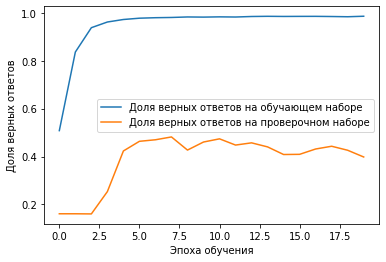

НЕЙРОНКА:  Embedding + Dense

О. Генри  распознано  90 % сеть считает, что это  О. Генри ,  распознано ВЕРНО!
Стругацкие  распознано  3 % сеть считает, что это  Фрай ,  распознано НЕ ВЕРНО!
Булгаков  распознано  11 % сеть считает, что это  О. Генри ,  распознано НЕ ВЕРНО!
Саймак  распознано  24 % сеть считает, что это  О. Генри ,  распознано НЕ ВЕРНО!
Фрай  распознано  79 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдбери  распознано  24 % сеть считает, что это  О. Генри ,  распознано НЕ ВЕРНО!

Средний процент распознавания  39 %



In [0]:
modelEC = Sequential() # создаём последовательную модель нейросети
# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelEC.add(Embedding(maxWordsCount, 50, input_length=xLen))

modelEC.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelEC.add(BatchNormalization())  # добавляем слой нормализации данных
modelEC.add(Conv1D(20, 5, activation="relu", padding='same')) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
modelEC.add(Conv1D(20, 5, activation="relu", padding='same')) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
modelEC.add(MaxPooling1D(2)) # добавляем слой подвыборки/пулинга с функцией максимума
modelEC.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEC.add(BatchNormalization()) # добавляем слой нормализации данных
modelEC.add(GlobalMaxPooling1D()) # добавляем слой подвыборки/пулинга с функцией максимума(по всей длине входящей последовательности)
#modelEC.add(Flatten()) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
modelEC.add(Dense(20, activation="relu")) # добавляем полносвязный слой с указанием количества нейронов и функции активации
modelEC.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEC.add(BatchNormalization()) # добавляем слой нормализации данных
modelEC.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelEC.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = modelEC.fit(xTrain, 
                    yTrain, 
                    epochs=20,
                    batch_size=200,
                    validation_data=(xTest, yTest))

# Строим график для отображения динамики обучения и точности предсказания сети
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

pred = recognizeMultiClass(modelEC, xTest6Classes, "Embedding + Dense") #функция покажет какие классы и как распознаны верно

In [0]:
print(modelEC.summary()) # выведем на экран данные о модели

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 1000, 50)          1000000   
_________________________________________________________________
spatial_dropout1d_16 (Spatia (None, 1000, 50)          0         
_________________________________________________________________
batch_normalization_41 (Batc (None, 1000, 50)          200       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1000, 20)          5020      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1000, 20)          2020      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 500, 20)           0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 500, 20)         

Train on 15779 samples, validate on 5674 samples
Epoch 1/20
15779/15779 [==============================] - 4s 224us/sample - loss: 1.5823 - acc: 0.3974 - val_loss: 2.2837 - val_acc: 0.0740
Epoch 2/20
15779/15779 [==============================] - 1s 90us/sample - loss: 0.3208 - acc: 0.8800 - val_loss: 5.3224 - val_acc: 0.3416
Epoch 3/20
15779/15779 [==============================] - 1s 90us/sample - loss: 0.0518 - acc: 0.9828 - val_loss: 5.4723 - val_acc: 0.0763
Epoch 4/20
15779/15779 [==============================] - 1s 89us/sample - loss: 0.0285 - acc: 0.9907 - val_loss: 5.0671 - val_acc: 0.3107
Epoch 5/20
15779/15779 [==============================] - 1s 89us/sample - loss: 0.0278 - acc: 0.9913 - val_loss: 1.8150 - val_acc: 0.5617
Epoch 6/20
15779/15779 [==============================] - 1s 90us/sample - loss: 0.0212 - acc: 0.9938 - val_loss: 1.4070 - val_acc: 0.7046
Epoch 7/20
15779/15779 [==============================] - 1s 90us/sample - loss: 0.0167 - acc: 0.9949 - val_loss: 2.

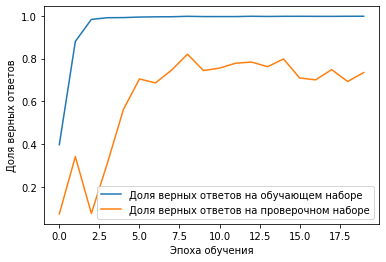

НЕЙРОНКА:  Embedding + Dense

О. Генри  распознано  100 % сеть считает, что это  О. Генри ,  распознано ВЕРНО!
Стругацкие  распознано  35 % сеть считает, что это  Стругацкие ,  распознано ВЕРНО!
Булгаков  распознано  80 % сеть считает, что это  Булгаков ,  распознано ВЕРНО!
Саймак  распознано  22 % сеть считает, что это  О. Генри ,  распознано НЕ ВЕРНО!
Фрай  распознано  78 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдбери  распознано  99 % сеть считает, что это  Брэдбери ,  распознано ВЕРНО!

Средний процент распознавания  73 %



In [0]:
modelEC = Sequential() # создаём последовательную модель нейросети
# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelEC.add(Embedding(maxWordsCount, 10, input_length=xLen))

modelEC.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelEC.add(BatchNormalization())  # добавляем слой нормализации данных
modelEC.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
modelEC.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
modelEC.add(MaxPooling1D(2)) # добавляем слой подвыборки/пулинга с функцией максимума
modelEC.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEC.add(BatchNormalization()) # добавляем слой нормализации данных
modelEC.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
modelEC.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
modelEC.add(MaxPooling1D(2)) # добавляем слой подвыборки/пулинга с функцией максимума
modelEC.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEC.add(BatchNormalization()) # добавляем слой нормализации данных
modelEC.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
modelEC.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
modelEC.add(MaxPooling1D(2)) # добавляем слой подвыборки/пулинга с функцией максимума
modelEC.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEC.add(BatchNormalization()) # добавляем слой нормализации данных
modelEC.add(Flatten()) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
modelEC.add(Dense(64, activation='relu')) # добавляем полносвязный слой на 64 нейрона, с функцией активации relu
modelEC.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelEC.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = modelEC.fit(xTrain, 
                    yTrain, 
                    epochs=20,
                    batch_size=200,
                    validation_data=(xTest, yTest))

# Строим график для отображения динамики обучения и точности предсказания сети
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

pred = recognizeMultiClass(modelEC, xTest6Classes, "Embedding + Dense") #функция покажет какие классы и как распознаны верно

In [0]:
modelEC = Sequential() # создаём последовательную модель нейросети
# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelEC.add(Embedding(maxWordsCount, 50, input_length=xLen))

modelEC.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelEC.add(BatchNormalization())  # добавляем слой нормализации данных
modelEC.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
modelEC.add(MaxPooling1D(2)) # добавляем слой подвыборки/пулинга с функцией максимума
modelEC.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEC.add(BatchNormalization()) # добавляем слой нормализации данных
modelEC.add(GlobalMaxPooling1D()) # добавляем слой подвыборки/пулинга с функцией максимума(по всей длине входящей последовательности)
#modelEC.add(Flatten()) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
modelEC.add(Dense(20, activation="relu")) # добавляем полносвязный слой с указанием количества нейронов и функции активации
modelEC.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEC.add(BatchNormalization()) # добавляем слой нормализации данных
modelEC.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelEC.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

print(modelEC.summary()) # выведем на экран данные о модели

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 1000, 50)          1000000   
_________________________________________________________________
spatial_dropout1d_17 (Spatia (None, 1000, 50)          0         
_________________________________________________________________
batch_normalization_44 (Batc (None, 1000, 50)          200       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 996, 20)           5020      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 498, 20)           0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 498, 20)           0         
_________________________________________________________________
batch_normalization_45 (Batc (None, 498, 20)         

**LSTM + Conv1D**

*Разбор данного раздела:* https://youtu.be/6KmWDCavCtw?t=5790

Epoch 1/5
89/89 [==============================] - 13s 145ms/step - loss: 0.6219 - accuracy: 0.7518 - val_loss: 2.7469 - val_accuracy: 0.1969
Epoch 2/5
89/89 [==============================] - 12s 135ms/step - loss: 0.0595 - accuracy: 0.9818 - val_loss: 3.4860 - val_accuracy: 0.1969
Epoch 3/5
89/89 [==============================] - 12s 135ms/step - loss: 0.0354 - accuracy: 0.9894 - val_loss: 3.5467 - val_accuracy: 0.2017
Epoch 4/5
89/89 [==============================] - 12s 134ms/step - loss: 0.0220 - accuracy: 0.9929 - val_loss: 4.2516 - val_accuracy: 0.3590
Epoch 5/5
89/89 [==============================] - 12s 134ms/step - loss: 0.0201 - accuracy: 0.9941 - val_loss: 8.9961 - val_accuracy: 0.2742


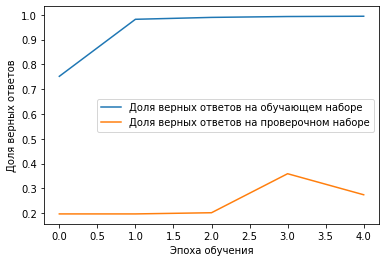

НЕЙРОНКА:  Embedding + Dense

О. Генри  распознано  0 % сеть считает, что это  Булгаков ,  распознано НЕ ВЕРНО!
Стругацкие  распознано  58 % сеть считает, что это  Стругацкие ,  распознано ВЕРНО!
Булгаков  распознано  91 % сеть считает, что это  Булгаков ,  распознано ВЕРНО!
Саймак  распознано  0 % сеть считает, что это  Стругацкие ,  распознано НЕ ВЕРНО!
Фрай  распознано  0 % сеть считает, что это  Стругацкие ,  распознано НЕ ВЕРНО!
Брэдбери  распознано  0 % сеть считает, что это  Стругацкие ,  распознано НЕ ВЕРНО!

Средний процент распознавания  27 %



In [0]:
modelEC = Sequential() # создаём последовательную модель нейросети
# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelEC.add(Embedding(maxWordsCount, 10, input_length=xLen))

modelEC.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelEC.add(LSTM(4, return_sequences=1)) # добавляем слой LSTM, совместимый с Cuda при поддержке GPU
modelEC.add(Dense(100, activation='relu')) # добавляем полносвязный слой с указанием количества нейронов и функции активации
modelEC.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
modelEC.add(LSTM(4, return_sequences=1)) # добавляем слой LSTM, совместимый с Cuda при поддержке GPU
modelEC.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEC.add(BatchNormalization()) # добавляем слой нормализации данных
modelEC.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
modelEC.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
modelEC.add(MaxPooling1D(2)) # добавляем слой подвыборки/пулинга с функцией максимума
modelEC.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEC.add(BatchNormalization()) # добавляем слой нормализации данных
modelEC.add(Flatten()) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
modelEC.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelEC.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = modelEC.fit(xTrain, 
                    yTrain, 
                    epochs=5,
                    batch_size=200,
                    validation_data=(xTest, yTest))

# Строим график для отображения динамики обучения и точности предсказания сети
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

pred = recognizeMultiClass(modelEC, xTest6Classes, "Embedding + Dense") #функция покажет какие классы и как распознаны верно

In [0]:
modelEC = Sequential() # создаём последовательную модель нейросети
# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelEC.add(Embedding(maxWordsCount, 10, input_length=xLen))

modelEC.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelEC.add(LSTM(4, return_sequences=1)) # добавляем слой LSTM, совместимый с Cuda при поддержке GPU
modelEC.add(Dense(100, activation='relu')) # добавляем полносвязный слой с указанием количества нейронов и функции активации
modelEC.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
modelEC.add(LSTM(4, return_sequences=1)) # добавляем слой LSTM, совместимый с Cuda при поддержке GPU
modelEC.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEC.add(BatchNormalization()) # добавляем слой нормализации данных
modelEC.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
modelEC.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
modelEC.add(MaxPooling1D(2)) # добавляем слой подвыборки/пулинга с функцией максимума
modelEC.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEC.add(BatchNormalization()) # добавляем слой нормализации данных
modelEC.add(Flatten()) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
modelEC.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelEC.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

print(modelEC.summary()) # выведем на экран данные о модели

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 1000, 10)          200000    
_________________________________________________________________
spatial_dropout1d_19 (Spatia (None, 1000, 10)          0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 1000, 4)           240       
_________________________________________________________________
dense_34 (Dense)             (None, 1000, 100)         500       
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 996, 20)           10020     
_________________________________________________________________
lstm_14 (LSTM)               (None, 996, 4)            400       
_________________________________________________________________
dropout_26 (Dropout)         (None, 996, 4)          

In [0]:
print(modelEC.summary()) # выведем на экран данные о модели

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 1000, 10)          200000    
_________________________________________________________________
spatial_dropout1d_19 (Spatia (None, 1000, 10)          0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 1000, 4)           240       
_________________________________________________________________
dense_34 (Dense)             (None, 1000, 100)         500       
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 996, 20)           10020     
_________________________________________________________________
lstm_14 (LSTM)               (None, 996, 4)            400       
_________________________________________________________________
dropout_26 (Dropout)         (None, 996, 4)          

**Conv1D + LSTM**

Epoch 1/5
89/89 [==============================] - 4s 44ms/step - loss: 1.0646 - accuracy: 0.6184 - val_loss: 2.6722 - val_accuracy: 0.1611
Epoch 2/5
89/89 [==============================] - 3s 39ms/step - loss: 0.0633 - accuracy: 0.9789 - val_loss: 3.8975 - val_accuracy: 0.1611
Epoch 3/5
89/89 [==============================] - 3s 39ms/step - loss: 0.0173 - accuracy: 0.9943 - val_loss: 3.8863 - val_accuracy: 0.1611
Epoch 4/5
89/89 [==============================] - 3s 39ms/step - loss: 0.0162 - accuracy: 0.9950 - val_loss: 4.4081 - val_accuracy: 0.3043
Epoch 5/5
89/89 [==============================] - 3s 39ms/step - loss: 0.0111 - accuracy: 0.9967 - val_loss: 4.4058 - val_accuracy: 0.3635


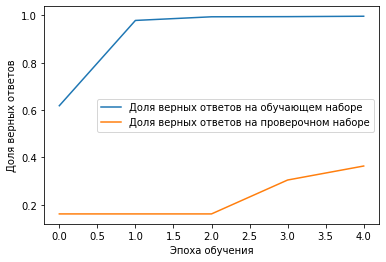

НЕЙРОНКА:  Embedding + Dense

О. Генри  распознано  18 % сеть считает, что это  Стругацкие ,  распознано НЕ ВЕРНО!
Стругацкие  распознано  100 % сеть считает, что это  Стругацкие ,  распознано ВЕРНО!
Булгаков  распознано  0 % сеть считает, что это  Стругацкие ,  распознано НЕ ВЕРНО!
Саймак  распознано  10 % сеть считает, что это  Стругацкие ,  распознано НЕ ВЕРНО!
Фрай  распознано  61 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдбери  распознано  0 % сеть считает, что это  Стругацкие ,  распознано НЕ ВЕРНО!

Средний процент распознавания  36 %



In [0]:
modelEC = Sequential() # создаём последовательную модель нейросети
# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelEC.add(Embedding(maxWordsCount, 10, input_length=xLen))

modelEC.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelEC.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров
modelEC.add(MaxPooling1D(2)) # добавляем слой подвыборки/пулинга с функцией максимума
modelEC.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEC.add(BatchNormalization()) # добавляем слой нормализации данных
modelEC.add(LSTM(4, return_sequences=1)) # добавляем слой LSTM, совместимый с Cuda при поддержке GPU
modelEC.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEC.add(BatchNormalization()) # добавляем слой нормализации данных
modelEC.add(Flatten()) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
modelEC.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelEC.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = modelEC.fit(xTrain, 
                    yTrain, 
                    epochs=5,
                    batch_size=200,
                    validation_data=(xTest, yTest))

# Строим график для отображения динамики обучения и точности предсказания сети
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

pred = recognizeMultiClass(modelEC, xTest6Classes, "Embedding + Dense") # функция покажет какие классы и как распознаны верно

**Дообучение**

Epoch 1/5
89/89 [==============================] - 6s 63ms/step - loss: 1.9061 - accuracy: 0.1921 - val_loss: 1.7672 - val_accuracy: 0.2916
Epoch 2/5
89/89 [==============================] - 5s 59ms/step - loss: 1.7676 - accuracy: 0.2623 - val_loss: 1.7505 - val_accuracy: 0.2928
Epoch 3/5
89/89 [==============================] - 5s 59ms/step - loss: 1.7004 - accuracy: 0.3097 - val_loss: 1.7343 - val_accuracy: 0.2928
Epoch 4/5
89/89 [==============================] - 5s 58ms/step - loss: 1.6498 - accuracy: 0.3430 - val_loss: 1.7166 - val_accuracy: 0.2922
Epoch 5/5
89/89 [==============================] - 5s 59ms/step - loss: 1.6121 - accuracy: 0.3611 - val_loss: 1.7019 - val_accuracy: 0.2964
Epoch 1/5
89/89 [==============================] - 6s 62ms/step - loss: 1.5592 - accuracy: 0.3792 - val_loss: 1.6752 - val_accuracy: 0.3145
Epoch 2/5
89/89 [==============================] - 5s 58ms/step - loss: 1.4876 - accuracy: 0.4066 - val_loss: 1.6559 - val_accuracy: 0.3314
Epoch 3/5
89/89 [===

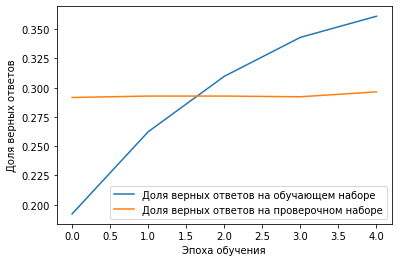

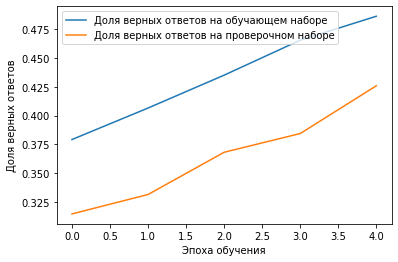

НЕЙРОНКА:  Embedding + LSTM

О. Генри  распознано  0 % сеть считает, что это  Стругацкие ,  распознано НЕ ВЕРНО!
Стругацкие  распознано  37 % сеть считает, что это  Стругацкие ,  распознано ВЕРНО!
Булгаков  распознано  57 % сеть считает, что это  Булгаков ,  распознано ВЕРНО!
Саймак  распознано  1 % сеть считает, что это  Фрай ,  распознано НЕ ВЕРНО!
Фрай  распознано  79 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдбери  распознано  9 % сеть считает, что это  Стругацкие ,  распознано НЕ ВЕРНО!

Средний процент распознавания  42 %



In [0]:
modelEL = Sequential() # создаём последовательную модель нейросети
# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelEL.add(Embedding(maxWordsCount, 10, input_length=xLen))

modelEL.add(SpatialDropout1D(0.4)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelEL.add(BatchNormalization()) # добавляем слой нормализации данных
modelEL.add(GRU(4)) # добавляем слой GRU, совместимый с Cuda при поддержке GPU
modelEL.add(Dropout(0.5)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEL.add(BatchNormalization()) # добавляем слой нормализации данных
modelEL.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelEL.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history1 = modelEL.fit(xTrain, 
                    yTrain, 
                    epochs=5,
                    batch_size=200,
                    validation_data=(xTest, yTest))
# Снова компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelEL.compile(optimizer='rmsprop', 
             loss='categorical_crossentropy', 
             metrics=['accuracy'])

# Дообучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history2 = modelEL.fit(xTrain, 
                    yTrain, 
                    epochs=5,
                    batch_size=200,
                    validation_data=(xTest, yTest))

# Строим 1й график для отображения динамики обучения и точности предсказания сети
plt.plot(history1.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history1.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

# Строим 2й график для отображения динамики обучения и точности предсказания сети
plt.plot(history2.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history2.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

pred = recognizeMultiClass(modelEL, xTest6Classes, "Embedding + LSTM") # функция покажет какие классы и как распознаны верно